# Development of the utility-maximization method for computing an optimal assignment

The actual library code is in `assignment.py`. In this notebook we walk through the theory, 
and include lots of sanity checks that the
formulae in the implementation are actually doing the right thing.

In [2]:
import cvxopt
import numpy as np
import pandas
import collections
import scipy.optimize
import matplotlib.pyplot as plt

# 1. Nonlinear convex optimization

A review of the convex optimization library [cvxopt](https://cvxopt.org/userguide/solvers.html):

\begin{align}
&\text{minimize} &&f_0(x)\\
&\text{subject to} &&f_k(x)\leq 0,\quad k=1,\dots,m\\
&&&Gx \preceq_C h\\
&&&Ax = b
\end{align}

The functions $f_k$ are required to be convex and twice differentiable.
The _generalized inequality_ $Gx\preceq_C h$ means $Gx - h \in \operatorname{int} C$ where $C$ is a "proper convex cone". If the cone in question is $C=\mathbb{R}_+^d$ (the default) then $Gx \preceq_C h$ means $Gx-h\in\mathbb{R}_+^d$ i.e. $Gx\leq h$ componentwise.

```
cvxopt.solvers.cp(F, G, h, dims, A, b)

F()
    returns (m, x0) where x0 is a matrix of size n×1, and is feasible
F(x) where x is a matrix of size n×1
    returns (f, Df)
        f is a (m+1)×1 matrix, with the values of the f_k functions
        Df is a (m+1)×n matrix, with Df[k,:] equal to the gradient of the f_k function
F(x,z) where x and z are matrices of sizes n×1 and (m+1)×n respectively
    returns (f, Df, H)
        f, Df are as above
        H is a square matrix of size n×n, equal to Σ_k z_k ∇^2 f_k(x)
h and b
    single-column matrices
G and A
    matrices
dims
    specifies the cone; leaving it at its default corresponds to the componentwise constraint Gx <= h
    
Returns a dictionary with these keys:

status
    optimal / unknown
x
    primal solution
y
    dual variables associated with the equality constraints,
    for the Lagrangian f_0(x) + Σ_k y_k [Ax - b]_k
```

### Dummy example

\begin{align}
&\text{minimize} && p^2+2 q^2\\
&\text{over} && p,q\in[0,1]\\
&\text{such that} && p+q=1
\end{align}

In [ ]:
def as_column(x):
    return np.array(x).reshape(-1,1)
def m(x):
    return cvxopt.matrix(x, tc='d')

def F(x=None, z=None):
    if x is None and z is None:
        return (0, m(as_column([0,0])))
    ([p],[q]) = np.array(x)
    f = as_column(p*p + 2*q*q)
    Df = np.zeros((1,2))
    Df[0,:] = [2*p, 4*q]
    if z is None:
        return (m(f), m(Df))
    [[z]] = np.array(z)
    H = np.array([[2,0],[0,4]]) * z
    return (m(f), m(Df), m(H))

G = m(np.array([[-1,0],[1,0],[0,-1],[0,1]]))
h = m(as_column([0,1,0,1]))
A = m(np.array([[1,1]]))
b = m(as_column(1))

res = cvxopt.solvers.cp(F, G=G, h=h, A=A, b=b)

In [ ]:
np.array(res['x'])

In [ ]:
np.array(res['y'])

\begin{align}
&\text{minimize} && p^2+2 q^2\\
&\text{over} && p,q\in[0,1]\\
&\text{such that} && pq \geq 0.5
\end{align}

Algebraic solution: the constraints require $p,q\in[.5,1]$, and the minimum will be at $q=0.5/p$, so the objective is $p^2+1/(2p^2)$, minimized at $p=2^{-1/4}=0.8409$.

In [6]:
def m(x):
    return cvxopt.matrix(x, tc='d')

def F(x=None, z=None):
    if x is None and z is None:
        x0 = np.array([.8,.8])
        return (1, m(x0[:,None]))
    ([p],[q]) = np.array(x)
    f = np.array([p*p + 2*q*q, 0.5 - p*q])[:,None]
    Df = np.array([[2*p, 4*q], [-q, -p]])
    if z is None:
        return (m(f), m(Df))
    [[z0],[z1]] = np.array(z)
    H0 = np.array([[2,0],[0,4]])
    H1 = np.array([[0,-1],[-1,0]])
    H = z0*H0 + z1*H1
    return (m(f), m(Df), m(H))

G = np.array([[-1,0],[1,0],[0,-1],[0,1]])
h = np.array([[0,1,0,1]]).T

res = cvxopt.solvers.cp(F, G=m(G), h=m(h))

np.array(res['x'])

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.2000e-01  6e+00  1e+00  1e+00
 1: -9.2297e-02 -3.1119e-01  2e+00  4e-01  4e-01
 2:  1.4581e+00  9.2255e-01  8e-01  1e-01  4e-01
 3:  1.4666e+00  1.3838e+00  9e-02  4e-03  4e-02
 4:  1.4192e+00  1.4121e+00  9e-03  6e-04  4e-03
 5:  1.4143e+00  1.4142e+00  2e-04  1e-05  7e-05
 6:  1.4142e+00  1.4142e+00  2e-06  1e-07  7e-07
 7:  1.4142e+00  1.4142e+00  2e-08  1e-09  7e-09
Optimal solution found.


array([[0.84089642],
       [0.59460356]])

# Simple one-link illustration

Consider a single link, where the rideshare price is $\mu$ and the rideshare operating cost is $\textit{vc}$.
At price $\mu$, the operator's profit is
$$
\operatorname{profit}(\mu) = \hat{\alpha}(\mu) \; \bigl(\mu-\textit{vc}\bigr)
$$
where $\hat{\alpha}$ is the demand function
$$
\hat{\alpha}(\mu) 
= \frac{e^{\text{bias}-\text{psen}\,\mu}}{1+e^{\text{bias}-\text{psen}\,\mu}}
= \operatorname*{arg\,max}_\alpha \Bigl\{\alpha\bigl(\text{bias}-\text{psen}\,\mu\bigr) + H(\alpha,1-\alpha)\Bigr\}\\
$$
and where $\text{bias}$ and $\text{psen}$ are coefficients from the discrete choice model.

At the profit-maximizing price $\hat{\mu}$, it can be shown (using simple calculus) that the corresponding $\hat{\alpha}$ solves
$$
\hat{\alpha} = \operatorname*{arg\,max}_\alpha \Bigl\{\alpha\bigl(\text{bias}-\text{psen}\,\textit{vc}\bigr) + H(\alpha,1-\alpha) + \log(1-\alpha)\Bigr\}
$$
and furthermore that
$$
\hat{\mu} = \textit{vc} + \frac{1}{\text{psen}(1-\hat{\alpha})}
$$

In [25]:
bias_rs = 1
pricesen_rs = 2
bias_bus = .5
vehicle_cost = 2

def logit(p): return np.log(p/(1-p))
def invlogit(x): return np.exp(x) / (1 + np.exp(x))

def U(α,μ):
    return α*(bias_rs-μ*pricesen_rs) + (1-α)*bias_bus - α*np.log(α) - (1-α)*np.log(1-α)

def optα(μ):
    return invlogit(bias_rs - bias_bus - pricesen_rs*μ)

In [4]:
# Demand as a function of price

[x] = scipy.optimize.fmin(lambda x: -U(α=invlogit(x),μ=2.5), x0=0)
print("utility max:", invlogit(x))
print("logistic theory:", optα(μ=2.5))

Optimization terminated successfully.
         Current function value: -0.511048
         Iterations: 29
         Function evaluations: 58
utility max: 0.010986942630593122
logistic theory: 0.01098694263059318


In [5]:
# Derivative of the demand function:
# should be - pricesen_rs * α * (1-α)

δ = 0.001
μ = 1.4
α = optα(μ)
((optα(μ+δ) - optα(μ))/δ, -pricesen_rs*α*(1-α))

(-0.16550373745732871, -0.1656391339814823)

Optimization terminated successfully.
         Current function value: -0.005494
         Iterations: 18
         Function evaluations: 36
2.505468750000004 0.010868726708859262


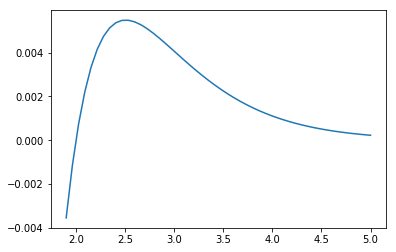

In [6]:
# Profit maximization.
# Observe that profit is not a convex function of price, so it's not amenable to nice
# simple convex optimization.

def net_profit(μ): return (μ - vehicle_cost) * optα(μ)

[optμ] = scipy.optimize.fmin(lambda x: -net_profit(x), x0=1)
print(optμ, optα(optμ))

μ = np.linspace(1.9,5)
plt.plot(μ, net_profit(μ))
plt.show()

In [119]:
# Implied utility version of profix maximization:
# maximizing profit is equivalent to maximizing U(α,vc) + log(1-α)

def implied_utility(α): return U(α, vehicle_cost) + np.log(1-α)
[x] = scipy.optimize.fmin(lambda x: - implied_utility(α=invlogit(x)), x0=0)
α = invlogit(x)
α

Optimization terminated successfully.
         Current function value: -0.510988
         Iterations: 29
         Function evaluations: 58


0.010868054817056674

In [120]:
# Relationship between price (μ) and rideshare fraction (α):
# at the optimum, μ = vc + 1/(psen*(1-α))

vehicle_cost + 1/(pricesen_rs*(1-α))

2.505493733606514

# 2. The assignment model as a convex optimization

Our utility maximization problem is

\begin{align}
&\text{maximize} && 
\sum_{i,j} \Bigl\{ 
\frac{d_{i j}}{\text{psen}_{i j}} \Bigl[
  U_{i j}(\alpha_{i j}, \textit{vc}_{i j}) + \log(1-\alpha_{i j})
  \Bigr]
  - \beta_{i j} \textit{vc}_{i j}
  \Bigr\}\\
&\text{over} && \alpha_{i j}\in[0,1],\; \beta_{i j}\geq 0\\
&\text{such that} && 
\sum_i \Bigl(d_{i k}\alpha_{i k}+\beta_{i k}\Bigr)
- \sum_j \Bigl(d_{k j}\alpha_{k j}+\beta_{k j}\Bigr)
=0
\quad\text{for all }k
\end{align}
where
\begin{align}
U(\alpha,c) &= \alpha(\text{bias}-\text{psen}\, c) + (1-\alpha)(\text{bias}'-\text{psen}' \textit{bp}) + H(\alpha,1-\alpha)\\
H(\alpha,1-\alpha) &= - \alpha \log \alpha - (1-\alpha)\log(1-\alpha).
\end{align}
The parameters here are
* $\alpha_{i j}$ is the fraction of demand from $i$ to $j$ that chooses rideshare
* $d_{i j}$ is the total demand
* $\beta_{i j}$ is the rebalancing flow
* $\textit{bp}_{i j}$ is the bus price
* $\textit{vc}_{i j}$ is the vehicle cost
* $\text{bias}_{i j}$ and $\text{psen}_{i j}$ are fitted coefficients from the discrete choice model: 
the utility for a rideshare trip at price $c$ is $(\text{bias} - \text{psen}\,c)$
* $\text{bias}'_{i j}$ and $\text{psen}'_{i j}$ are fitted coefficients for bus:
the utility for a bus trip at price $\textit{bp}$ is $(\text{bias}' - \text{psen}'\textit{bp})$

Note that the utility-maximization theory only works when the rideshare operator is free to set per-route prices.
I don't think it can accommodate constraints like "all prices at a given node must be of the form surge multiplier times vehicle cost".

To translate our problem into cvxopt terminology,

* $x$ is the vector with $\alpha$, $\beta$ concatenated
* $n=2|E|$ is the dimension of $x$
* $f_0(x)$ is the negative of our objective, and $m=0$
* $Gx \leq h$ implements the bounds on $\alpha$ and $\beta$, $3|E|$ constraints in total, and the default cone is sufficient
* $Ax = b$ implements the circulation constraint, $|V|$ constraints in total

In [11]:
Route = collections.namedtuple('Route', ['src','dst','demand','vehicle_cost','bus_price'])

routes = pandas.DataFrame([Route(src=0, dst=1, demand=10, vehicle_cost=1.5, bus_price=1),
                           Route(src=1, dst=0, demand=2, vehicle_cost=1.5, bus_price=6)])
routes['u_rideshare_bias'] = 1.55393376
routes['u_rideshare_pricesen'] = 0.3034984
routes['u_bus_bias'] = 0
routes['u_bus_pricesen'] = 0.09368271

# The code below needs len(nodes), nothing more; but why not populate it with something useful?
nodes = pandas.DataFrame({'id': [0,1], 'lat': [37.834,37.802], 'long': [-122.482,-122.461]})

In [12]:
E = len(routes)
d,vc,bp = routes['demand'], routes['vehicle_cost'], routes['bus_price']
bias,psen = routes['u_rideshare_bias'], routes['u_rideshare_pricesen']
biasp,psenp = routes['u_bus_bias'], routes['u_bus_pricesen']

# cvxopt has its own matrix type; I'll do all my code in numpy and convert to cvxopt at the last minute
def m(x): return cvxopt.matrix(x, tc='d')

In [13]:
# Find a feasible circulation given rideshare demand
α0 = np.full_like(d, 0.5, dtype=np.float32)
A = np.zeros((len(nodes), len(d)))
for ri,(src,dst) in enumerate(zip(routes['src'],routes['dst'])):
    A[src,ri] = 1
    A[dst,ri] = -1
G = - np.identity(len(d))
h = np.zeros_like(d)
b = - (A @ d*α0)
res = cvxopt.solvers.lp(c=m(vc), G=m(G), h=m(h), A=m(A[:-1]), b=m(b[:-1]))
β0 = np.array(res['x'])[:,0]
β0[np.isclose(β0,0)] = 0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  9e+00  4e+00  0e+00  1e+00
 1:  5.7974e+00  5.9400e+00  8e-01  5e-01  2e-16  2e-01
 2:  5.9977e+00  5.9992e+00  8e-03  5e-03  2e-16  3e-03
 3:  6.0000e+00  6.0000e+00  8e-05  5e-05  4e-16  3e-05
 4:  6.0000e+00  6.0000e+00  8e-07  5e-07  1e-16  3e-07
 5:  6.0000e+00  6.0000e+00  8e-09  5e-09  2e-16  3e-09
Optimal solution found.


In [14]:
def entropy(p):
    '''Computes the entropy H(p,1-p), and its first and second derivatives'''
    p = np.array(p)
    # To avoid warnings when p=0 or p-1, use escape clauses
    safe = (p>0) & (p<1)
    psafe = np.where(safe, p, 0.5)
    f = np.where(safe, - p*np.log(psafe) - (1-p)*np.log(1-psafe), 0)
    Df = np.where(safe, np.log((1-psafe)/psafe), np.where(p<.5, np.inf, -np.inf))
    D2f = np.where(safe, - 1/p - 1/(1-p), -np.inf)
    return (f,Df,D2f)

def profit(p):
    '''Computes the profit term log(1-p), and its first and second derivatives'''
    p = np.array(p)
    # To avoid warnings when p=1, use escape clauses
    safe = p<1
    p = np.where(safe, p, 0.5)
    f = np.where(safe, np.log(1-p), -np.inf)
    Df = np.where(safe, -1/(1-p), -np.inf)
    D2f = np.where(safe, -np.power(1-p,-2), -np.inf)
    return (f,Df,D2f)

def objective(include_profit=True):
    def F(x=None, z=None):
        if x is None and z is None:
            x0 = np.concatenate([α0,β0])
            return (0, m(x0))
        x = np.array(x).reshape(-1)
        α,β = x[:E], x[E:]
        (entr,Dentr,D2entr) = entropy(α)
        (prof,Dprof,D2prof) = profit(α) if include_profit else np.zeros((3,E))
        implied_utility = d/psen * (α*(bias-psen*vc) + (1-α)*(biasp-psenp*bp) + entr + prof) - β*vc
        Dα = d/psen * (bias-psen*vc - biasp+psenp*bp + Dentr + Dprof)
        Dβ = -vc
        f = - np.sum(implied_utility)
        Df = - np.concatenate([Dα,Dβ])
        if (z is None):
            return (m(f), m(Df[None,:]))
        [[z]] = np.array(z)
        Dαα = d/psen * (D2entr + D2prof)
        D2f = np.concatenate([- Dαα, np.zeros(E)])
        H = cvxopt.spmatrix(D2f, np.arange(2*E), np.arange(2*E))
        return (m(f), m(Df[None,:]), m(H))
    return F

F = objective(include_profit=True)

i = np.eye(E)
z = np.zeros((E,E))
G = np.block([[-i, z], [i, z], [z, -i]])
h = np.concatenate([np.zeros(E), np.ones(E), np.zeros(E)])

A = np.zeros((len(nodes), 2*E))
for e,(demand,src,dst) in enumerate(zip(d,routes['src'],routes['dst'])):
    A[src, e] = - demand
    A[dst, e] = demand
    A[src, e+E] = - 1
    A[dst, e+E] = 1
# Assuming the graph is strongly connected, we have one redundant equation,
# which we might as well take to be the last one.
A = A[:-1]
b = np.zeros(len(nodes)-1)

### Sanity check

I've defined constraints $Gx\leq h$ and $Ax=b$. Are these constraints satisfied for the initial guess?

In [15]:
x0 = np.array(F()[1])[:,0]
print((G @ x0 <= h) | np.isclose(G @ x0, h))
print(np.isclose(A @ x0, b))

[ True  True  True  True  True  True]
[ True]


I've also defined a function $F$ which is meant to return the first and second derivatives. It's a good idea to check they're right, with numerical differentiation:
$$
\frac{\partial f}{\partial x_i} 
\approx 
\frac{f(x+\delta e_i)-f(x-\delta e_i)}{2\delta}\\
\frac{\partial^2 f}{\partial x_i \partial x_j} 
\approx
\frac{f(x+\delta e_i + \delta e_j) - f(x+\delta e_i-\delta e_j) - f(x-\delta e_i+\delta e_j) + f(x-\delta e_i-\delta e_j)}{4\delta^2}
$$

In [16]:
def units(x):
    return [(np.arange(len(x))==i).astype(np.double) for i in range(len(x))]
def Dnum(f, x, δ):
    return np.array([(f(x+δ*e) - f(x-δ*e))/2/δ for e in units(x)])
def D2num(f, x, δ):
    return np.array([[(f(x+δ*ei+δ*ej)-f(x+δ*ei-δ*ej)-f(x-δ*ei+δ*ej)+f(x-δ*ei-δ*ej))/(4*δ*δ)
                      for ei in units(x)] for ej in units(x)])

In [17]:
_,x0 = F()
f,Df,D2f = F(x0,[[1]])

print("Derivative as reported by F:")
print(np.array(Df))
print("\nNumerical derivative:")
print(Dnum(lambda x: np.array(F(m(x))[0])[0,0], np.array(x0)[:,0], .01))

Derivative as reported by F:
[[26.61072118  2.23538299  1.5         1.5       ]]

Numerical derivative:
[26.61950971  2.23714069  1.5         1.5       ]


In [18]:
print("Hermitian as reported by F:")
print(np.round(np.array(D2f),5))
print("\nNumerical Hermitian:")
print(np.round(D2num(lambda x: np.array(F(m(x))[0])[0,0], np.array(x0)[:,0], .001), 5))

Hermitian as reported by F:
[[263.59282   0.        0.        0.     ]
 [  0.       52.71856   0.        0.     ]
 [  0.        0.        0.        0.     ]
 [  0.        0.        0.        0.     ]]

Numerical Hermitian:
[[263.59423   0.        0.        0.     ]
 [  0.       52.71885   0.        0.     ]
 [  0.        0.        0.        0.     ]
 [  0.        0.        0.        0.     ]]


### Verification

On the two-link network defined at the top of the file, it's not too much work to do an exhaustive manual search to find the optimal prices.

In [144]:
def logit(p): return np.log(p/(1-p))
def invlogit(x): return np.exp(x) / (1 + np.exp(x))

E = len(routes)
assert E==2
d,vc,bp = routes['demand'], routes['vehicle_cost'], routes['bus_price']
bias,psen = routes['u_rideshare_bias'], routes['u_rideshare_pricesen']
biasp,psenp = routes['u_bus_bias'], routes['u_bus_pricesen']

def optα(μ):
    μ = np.array(μ)
    u1 = bias - psen*μ
    u2 = biasp - psenp*bp
    return invlogit(u1 - u2)

def rebalance(dα):
    if dα[0]>dα[1]:
        return np.array([0,dα[0]-dα[1]]) 
    else:
        return np.array([dα[1]-dα[0],0])

def net_profit(μ): 
    dα = d * optα(μ)
    β = rebalance(dα)
    return np.sum(dα * μ - (dα + β) * vc)

In [145]:
# Check that rebalancing produces a balanced flow
α = optα([5,5])
β = rebalance(d * α)
A @ np.concatenate([α,β])

array([0.])

In [146]:
# Find the profit-maximizing price vector
optμ = scipy.optimize.fmin(lambda x: -net_profit(x), x0=[1,1])
print(optμ, list(optα(optμ)))

Optimization terminated successfully.
         Current function value: -22.698174
         Iterations: 57
         Function evaluations: 108
[7.86698585 6.7837411 ] [0.3230038929805614, 0.514289970231564]


In [153]:
res = cvxopt.solvers.cp(F, G=m(G), h=m(h[:,None]), A=m(A), b=m(b[:,None]))
x = np.array(res['x'])[:,0]
αopt,βopt = x[:E], x[E:]
ξopt = np.append(np.array(res['y']), 0)
(αopt, βopt, ξopt)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -1.8325e+01  7e+00  1e+00  1e+00
first lapack.potrf 0 4
[265.59282289  54.71856458   1.           1.        ]
[[265.59282   0.        0.        0.     ]
 [  0.       54.71856   0.        0.     ]
 [  0.        0.        1.        0.     ]
 [  0.        0.        0.        1.     ]]
 1: -8.8574e+00 -1.8833e+01  4e+00  6e-01  6e-01
 2: -1.3530e+01 -1.7028e+01  2e+00  2e-01  3e-01
 3: -1.6120e+01 -1.6272e+01  4e-01  2e-02  3e-03
 4: -1.5910e+01 -1.5913e+01  6e-03  3e-04  3e-05
 5: -1.5907e+01 -1.5907e+01  6e-05  3e-06  3e-07
 6: -1.5907e+01 -1.5907e+01  6e-07  3e-08  3e-09
Optimal solution found.


(array([0.32300524, 0.51429155]),
 array([3.85148525e-09, 2.20146927e+00]),
 array([-1.49999998,  0.        ]))

## Read off prices, shadow prices, profit

A network basically behaves like a collection of individual links, joined together through the shadow prices at each node.
Following the analysis of a single isolated link,
$$
\hat{\mu} = \textit{vc} + \xi_{\text{dst}} - \xi_{\text{src}} + \frac{1}{\text{psen}(1-\hat{\alpha})}
$$

In [154]:
rebalancing_cost = ξopt[routes['dst']] - ξopt[routes['src']]
profit = 1/(psen*(1-αopt))
vc + rebalancing_cost + profit

0    7.866966
1    6.783720
dtype: float64

# 3. Social welfare maximization

Our utility maximization problem is exactly the same as before but without the profit dis-utility term $\log(1-\alpha)$. In other words, the problem is

\begin{align}
&\text{maximize} && 
\sum_{i,j} \Bigl\{ 
\frac{d_{i j}}{\text{psen}_{i j}} U_{i j}(\alpha_{i j}, \textit{vc}_{i j})
  - \beta_{i j} \textit{vc}_{i j}
  \Bigr\}\\
&\text{over} && \alpha_{i j}\in[0,1],\; \beta_{i j}\geq 0\\
&\text{such that} && 
\sum_i \Bigl(d_{i k}\alpha_{i k}+\beta_{i k}\Bigr)
- \sum_j \Bigl(d_{k j}\alpha_{k j}+\beta_{k j}\Bigr)
=0
\quad\text{for all }k
\end{align}
where
\begin{align}
U(\alpha,c) &= \alpha(\text{bias}-\text{psen}\, c) + (1-\alpha)(\text{bias}'-\text{psen}' \textit{bp}) + H(\alpha,1-\alpha)\\
H(\alpha,1-\alpha) &= - \alpha \log \alpha - (1-\alpha)\log(1-\alpha).
\end{align}


In [19]:
res = cvxopt.solvers.cp(objective(include_profit=False), G=m(G), h=m(h[:,None]), A=m(A), b=m(b[:,None]))
x = np.array(res['x'])[:,0]
αopt,βopt = x[:E], x[E:]
ξopt = np.append(np.array(res['y']), 0)
(αopt, βopt, ξopt)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -4.5731e+01  7e+00  1e+00  1e+00
 1: -1.6736e+01 -4.6858e+01  5e+00  7e-01  7e-01
 2: -2.6606e+01 -4.5449e+01  3e+00  5e-01  5e-01
 3: -4.6286e+01 -4.5801e+01  9e-01  4e-02  5e-02
 4: -4.5175e+01 -4.5126e+01  6e-02  3e-03  4e-03
 5: -4.5077e+01 -4.5076e+01  2e-03  9e-05  1e-04
 6: -4.5074e+01 -4.5074e+01  2e-05  9e-07  2e-06
 7: -4.5074e+01 -4.5074e+01  2e-07  9e-09  2e-08
Optimal solution found.


(array([0.67636604, 0.89245149]),
 array([5.91779426e-09, 4.97875742e+00]),
 array([-1.49999999,  0.        ]))

In [28]:
rebalancing_cost = ξopt[routes['dst']] - ξopt[routes['src']]
price = vc + rebalancing_cost
price

0    3.000000e+00
1    9.248394e-09
Name: vehicle_cost, dtype: float64

In [29]:
d * αopt + βopt

0    6.76366
1    6.76366
Name: demand, dtype: float64

In [26]:
routes

,src,dst,demand,vehicle_cost,bus_price,u_rideshare_bias,u_rideshare_pricesen,u_bus_bias,u_bus_pricesen
0,0,1,10,1.5,1,1.553934,0.303498,0,0.093683
1,1,0,2,1.5,6,1.553934,0.303498,0,0.093683


In [32]:
u1 = bias - psen * price
u2 = biasp - psenp * bp
invlogit(u1 - u2)

0    0.676366
1    0.892451
dtype: float64